In [1]:
#计算水动力参数
import time
import numpy as np
import capytaine as cpt
import scipy
from capytaine.io.mesh_writers import write_STL
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import vtk
import logging
import xarray as xr
from capytaine.io.xarray import merge_complex_values
logging.basicConfig(level=logging.INFO, format='%(levelname)-8s: %(message)s')
from capytaine.post_pro import rao


In [2]:
# filepath = 'E:\phd\Code\DM-FEM2D\hydro_output\Time_test_twomodule.nc'
filepath = 'E:\phd\Code\DM-FEM2D\hydro_output\sphere_full.nc'
dataset = merge_complex_values(xr.open_dataset(filepath))

In [3]:
# 斜坡、波浪谱、不规则波激励力生成
# Define your ramp function, R_f(t), here
# For example, a simple linear ramp function that goes from 0 to 1 over the ramp time T_ramp:
def ramp_function(t, t_r):
    """
    Calculates the value of the ramp function R_f(t) at time t.

    Parameters:
    t (float): The current simulation time.
    t_r (float): The ramp time.

    Returns:
    float: The value of the ramp function at time t.
    """
    if t < t_r:
        return 0.5 * (1 + np.cos(np.pi + (np.pi * t) / t_r))
    else:
        return 1.0

# import Jonswap spectrum from Wave.py
# from Wave import jonswap 
def jonswap(Hs, Tp, gamma, omega):
    '''
        Hs: significant wave height
        Tp: peak period
        gamma: peak enhancement factor
        omega: 角频率
        jonswap wave spectrum, refrerence:
        https://www.sciencedirect.com/science/article/pii/S0960148116301446
        omega=2*pi*f, f为频率, omega为角频率,最终结果需要乘以2*pi
        以与论文结果对比验证
    '''
    fp = 2*np.pi/Tp
    # if omega.all() < fp:
    #     sigma = 0.07
    # else:
    #     sigma = 0.09
    sigma = np.where(omega <= fp, 0.07, 0.09)
    alpha = 0.0624 / (0.230 + 0.0336 * gamma - (0.185 / (1.9+gamma)))
    beta = np.exp(-(omega-fp)**2/(2*(sigma**2)*(fp**2)))
    return alpha*Hs**2*fp**4*omega**(-5)*gamma**beta*np.exp(-1.25*(fp/omega)**4)

# Now let's compute the wave excitation force for a given time t
# Updated wave_excitation_force function that uses xarray.DataArray
def wave_excitation_force(dataset, t, t_r, Hs, Tp, gamma):
    omega_range = dataset.omega  # omega_min and omega_max to be defined
    delta_omega = np.diff(omega_range)[0] # omega spacing
    R_f = ramp_function(t, t_r)  # Compute the ramp function value for time t
    jonswap_spectrum = jonswap(Hs, Tp, gamma, omega_range)  # Compute the JONSWAP spectrum for the omega range
    # Compute the excitation force using the provided datasets
    F_exc = dataset.Froude_Krylov_force + dataset.diffraction_force
    phi = np.random.uniform(0, 2*np.pi, size=len(omega_range))  # Random phase angles

    
    # Vectorized computation of the excitation components
    excitation_components = F_exc * np.exp(1j * (omega_range * t + phi)) * np.sqrt(2 * jonswap_spectrum * delta_omega)
    # Summation and taking the real part
    F_exc_t = np.real(R_f * np.sum(excitation_components, axis=0))
    return F_exc_t

In [4]:
# Wave parameters
Hs = 3  # Significant wave height
Tp = 8  # Peak period
gamma = 3.3  # Peak enhancement factor
t_r = 50  # Ramp time

# Time parameters and irf
from bemio import radiationIRF
irf = radiationIRF(dataset, tEnd=100, nDt=1001, nDw=1001, wMin=None, wMax=None)

# Generate the time series for the wave excitation force
time_series = irf.ra_t
excitation_force_series = np.array([wave_excitation_force(dataset, t, t_r, Hs, Tp, gamma) for t in time_series])

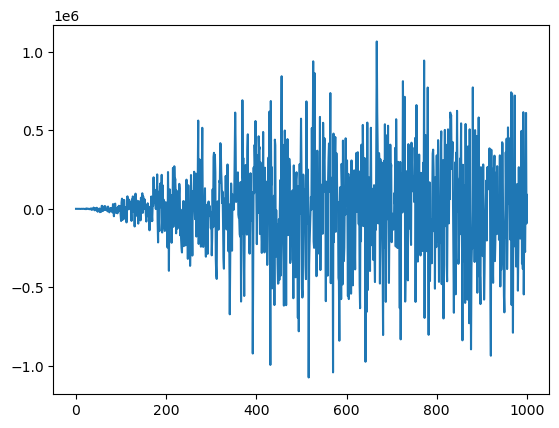

In [6]:
# 不规则波下的波浪力激励力
plt.plot(excitation_force_series[:,0,2])

In [7]:
irf

<xarray.Dataset>
Dimensions:              (omega: 420, radiating_dof: 6, influenced_dof: 6,
                          wave_direction: 1, time: 1001, dof1: 6, dof2: 6,
                          ra_t: 1001, ra_w: 1001)
Coordinates:
  * omega                (omega) float64 0.02 0.04 0.06 0.08 ... 8.36 8.38 8.4
    body_name            object ...
  * radiating_dof        (radiating_dof) object 'Surge' 'Sway' ... 'Pitch' 'Yaw'
  * influenced_dof       (influenced_dof) object 'Surge' 'Sway' ... 'Yaw'
  * wave_direction       (wave_direction) float64 0.0
    g                    float64 ...
    rho                  float64 ...
    water_depth          float64 ...
  * ra_t                 (ra_t) float64 0.0 0.1 0.2 0.3 ... 99.7 99.8 99.9 100.0
  * ra_w                 (ra_w) float64 0.02 0.02838 0.03676 ... 8.383 8.392 8.4
Dimensions without coordinates: time, dof1, dof2
Data variables:
    added_mass           (omega, radiating_dof, influenced_dof) float64 ...
    radiation_damping    (omega, radiating_dof, influenced_dof) float64 ...
    diffraction_force    (omega, wave_direction, influenced_dof) complex128 (...
    Froude_Krylov_force  (omega, wave_direction, influenced_dof) complex128 (...
    ra_K                 (time, dof1, dof2) float64 1.971e+05 ... -6.295e-08
    Ainf                 (dof1, dof2) float64 5.793e+04 3.038e-14 ... 2.429e-05
Attributes: (12/13)
    start_of_computation:                     2023-02-23T14:49:14.117237
    green_function:                           Delhommeau
    tabulation_nr:                            328
    tabulation_nz:                            46
    tabulation_nb_integration_points:         251
    finite_depth_prony_decomposition_method:  fortran
    ...                                       ...
    engine:                                   BasicMatrixEngine
    matrix_cache_size:                        1
    linear_solver:                            lu_decomposition
    creation_of_dataset:                      2023-02-23T15:21:07.024011
    incoming_waves_convention:                nemoh
    capytaine_version:                        1.5

In [8]:
# 将惯性力和静水恢复力加入到数据集
import pandas as pd
# Read the CSV file into a Pandas DataFrame
inertia_matrix = pd.read_csv('inertia_matrix_values.csv')
hydrostatic_stiffness = pd.read_csv('hydrostatic_stiffness_values.csv')

# Convert the DataFrames to xarray DataArrays
inertia_matrix_da = xr.DataArray(inertia_matrix.values, dims=["radiating_dof", "influenced_dof"])
hydrostatic_stiffness_da = xr.DataArray(hydrostatic_stiffness.values, dims=["radiating_dof", "influenced_dof"])

# Add the new DataArrays to 'irf'
irf["inertia_matrix"] = inertia_matrix_da
irf["hydrostatic_stiffness"] = hydrostatic_stiffness_da


In [1]:
irf

NameError: name 'irf' is not defined

(1001,)
k (6, 6)
F: (6,)
(6, 6)
(12,)
(6,)
convolution_integral: (6,)
dydt: (12,)
(6,)
convolution_integral: (6,)
dydt: (12,)
(6,)
convolution_integral: (6,)
dydt: (12,)
(6,)
convolution_integral: (6,)
dydt: (12,)
(6,)
convolution_integral: (6,)
dydt: (12,)
(6,)
convolution_integral: (6,)
dydt: (12,)
(6,)
convolution_integral: (6,)
dydt: (12,)
(6,)
convolution_integral: (6,)
dydt: (12,)
(6,)
convolution_integral: (6,)
dydt: (12,)
(6,)
convolution_integral: (6,)
dydt: (12,)
(6,)
convolution_integral: (6,)
dydt: (12,)
(6,)
convolution_integral: (6,)
dydt: (12,)
(6,)
convolution_integral: (6,)
dydt: (12,)
(6,)
convolution_integral: (6,)
dydt: (12,)
(6,)
convolution_integral: (6,)
dydt: (12,)
(6,)
convolution_integral: (6,)
dydt: (12,)
(6,)
convolution_integral: (6,)
dydt: (12,)
(6,)
convolution_integral: (6,)
dydt: (12,)
(6,)
convolution_integral: (6,)
dydt: (12,)
(6,)
convolution_integral: (6,)
dydt: (12,)
(6,)
convolution_integral: (6,)
dydt: (12,)
(6,)
convolution_integral: (6,)
dydt: 

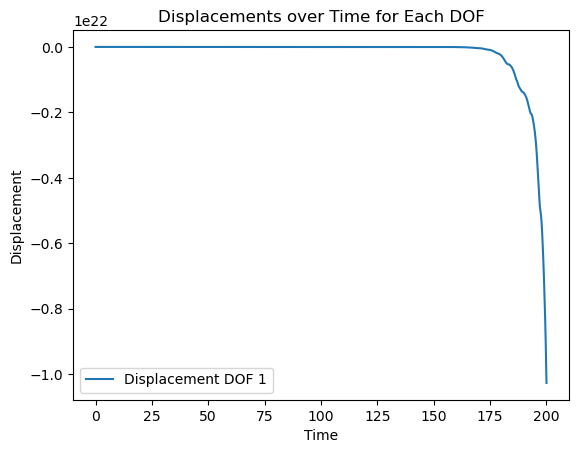

In [22]:
import numpy as np
import xarray as xr
from scipy.integrate import solve_ivp
from scipy.interpolate import RegularGridInterpolator

# 假设m, c, k, F是xarray格式的矩阵
# 例如，对于两个体，每个体有6个自由度
N = 1  # 体的数量
DOF_per_body = 6  # 每个体的自由度数量
DOF = N * DOF_per_body  # 总自由度数量
# 时间点
time_points = irf.ra_t.values
print(time_points.shape)


m = irf.inertia_matrix.values + irf.Ainf.values
c = 1
k = irf.hydrostatic_stiffness.values
print("k",k.shape)
interpolator_F = RegularGridInterpolator((time_points,), excitation_force_series, bounds_error=False, fill_value=np.zeros((1, DOF)))

def F(t):
    return interpolator_F([t])[0].squeeze()

print("F:",F(0.36).shape)
# 初始化历史速度的列表（全局变量）
history_y2 = []

RA_K = irf.ra_K.values

# 创建一个基于规则网格的插值函数
interpolator_Kr = RegularGridInterpolator((time_points,), RA_K, bounds_error=False, fill_value=np.zeros((DOF, DOF)))
# 使用插值函数来获取卷积核值
def Kr(t):
    return interpolator_Kr([t])[0]
print(Kr(0.36).shape)

# 定义方程组，包括卷积项
def system_equations_with_convolution(t, y):
    global history_y2
    #定义速度
    # 分离位移和速度
    displacement = y[:DOF]  # 位移 (12x1)
    velocity = y[DOF:]      # 速度 (12x1)
    # 初始化导数向量
    dydt = np.zeros(2 * DOF)
    # 计算位移导数（即速度）
    dydt[:DOF] = velocity

    print(displacement.shape)
    # 更新历史记录
    history_y2.append((t, velocity.copy()))
    history_y2 = history_y2[-100:]  # 保留最近100个时间点的历史

    convolution_integral = 0
    for tau, v in history_y2:
        # 获取历史时刻的卷积核矩阵
        historical_K = Kr(t - tau)
        # 计算当前自由度与所有其他自由度的相互作用
        convolution_integral += historical_K @ v * (t_eval[1] - t_eval[0])
    print("convolution_integral:",convolution_integral.shape)                           
    # 方程组
    import numpy.linalg as la
    dydt[DOF:] = la.inv(m) @ (F(t) - convolution_integral - k @ displacement)
    print("dydt:",dydt.shape)
    return dydt
# 初始条件
y0 = np.zeros(2 * DOF)
print(y0.shape)
# 定义时间区间
t_span = (0, 200)  # 从0到10秒
t_eval = np.linspace(*t_span, 2001)  # 生成时间点

# 求解ODE
solution = solve_ivp(system_equations_with_convolution, t_span, y0, t_eval=t_eval, method='RK45', dense_output=True)

# 提取结果
t = solution.t
displacement  = solution.y[:DOF].T
velocity = solution.y[DOF:].T

for i in range(N):
    plt.plot(t_eval, displacement[:, i], label=f'Displacement DOF {i+1}')
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.title('Displacements over Time for Each DOF')
plt.legend()
plt.show()



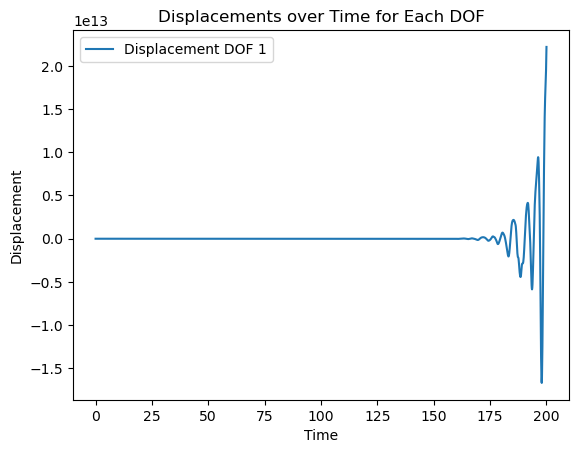

In [23]:

plt.plot(t_eval, displacement[:, 2], label=f'Displacement DOF {i+1}')
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.title('Displacements over Time for Each DOF')
plt.legend()
plt.show()

In [ ]:
# 提取结果
t = solution.t
y = solution.y.reshape((len(t_eval), N, 2*DOF))

# 绘制某个特定体和自由度的结果图像
selected_body = 0  # 选择的体
selected_dof = 0  # 选择的自由度

y1 = y[:, selected_body, selected_dof]  # 位移
y2 = np.gradient(y1, t_eval[1] - t_eval[0])  # 速度，通过位移的时间导数计算

plt.figure(figsize=(12, 6))
plt.plot(y1)
plt.show()

In [ ]:

# filepath = 'E:\phd\Code\DM-FEM2D\hydro_output\Time_test_twomodule.nc'
filepath = 'E:\phd\Code\DM-FEM2D\hydro_output\sphere_full.nc'
dataset = merge_complex_values(xr.open_dataset(filepath))

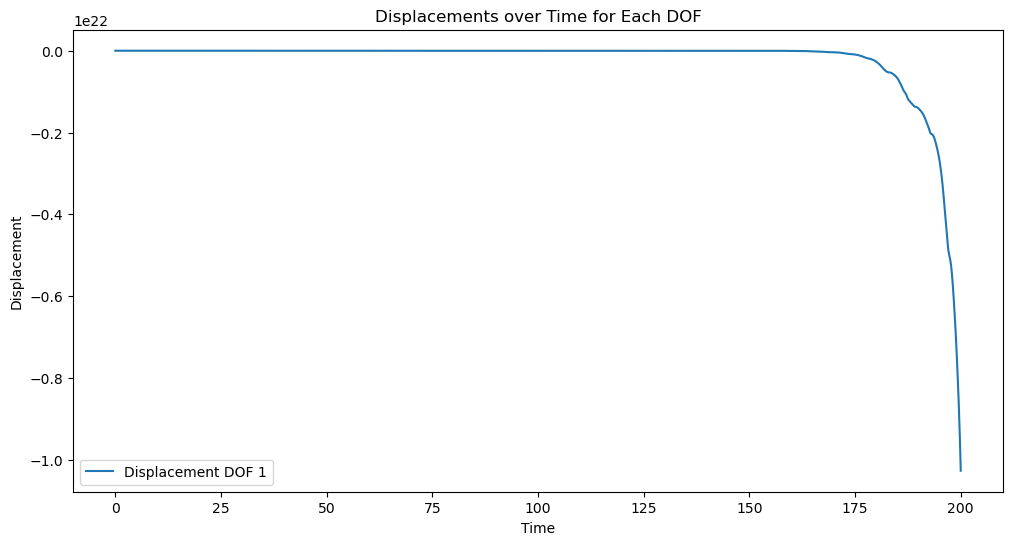

In [25]:
import numpy as np
import xarray as xr
from scipy.integrate import solve_ivp
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt

def simulate_dynamics(N, DOF_per_body, irf, excitation_force_series, t_span, num_time_points):
    """
    Simulates the dynamics of a multi-body system.

    Parameters:
    - N: Number of bodies.
    - DOF_per_body: Degrees of freedom per body.
    - irf: An object containing system parameters (inertia_matrix, Ainf, hydrostatic_stiffness, ra_t, ra_K).
    - excitation_force_series: Time series of the external forces.
    - t_span: Tuple indicating the time span of the simulation.
    - num_time_points: Number of time points in the simulation.

    Returns:
    - t: Time points of the simulation.
    - displacement: Displacement of each degree of freedom over time.
    - velocity: Velocity of each degree of freedom over time.
    """
    DOF = N * DOF_per_body  # Total degrees of freedom
    time_points = irf.ra_t.values  # Extract time points

    # System matrices
    m = irf.inertia_matrix.values + irf.Ainf.values
    k = irf.hydrostatic_stiffness.values

    # Interpolators for external force and convolution kernel
    interpolator_F = RegularGridInterpolator((time_points,), excitation_force_series, bounds_error=False, fill_value=np.zeros((1, DOF)))
    interpolator_Kr = RegularGridInterpolator((time_points,), irf.ra_K.values, bounds_error=False, fill_value=np.zeros((DOF, DOF)))

    def F(t):
        """ Interpolated external force at time t """
        return interpolator_F([t])[0].squeeze()

    def Kr(t):
        """ Interpolated convolution kernel at time t """
        return interpolator_Kr([t])[0]

    # Initialize history of velocities
    history_y2 = []

    def system_equations_with_convolution(t, y):
        """
        Defines the system of equations including the convolution term.

        Parameters:
        - t: Current time.
        - y: Current state of the system (displacement and velocity).

        Returns:
        - dydt: Derivatives of the system state.
        """
        nonlocal history_y2
        displacement, velocity = y[:DOF], y[DOF:]
        dydt = np.zeros(2 * DOF)
        dydt[:DOF] = velocity

        # Update history
        history_y2.append((t, velocity.copy()))
        history_y2 = history_y2[-100:]  # Keep only the last 100 time points

        # Convolution integral
        convolution_integral = np.zeros(DOF)
        for tau, v in history_y2:
            convolution_integral += Kr(t - tau) @ v * (t_eval[1] - t_eval[0])

        # Equation system
        dydt[DOF:] = np.linalg.inv(m) @ (F(t) - convolution_integral - k @ displacement)
        return dydt

    # Initial condition
    y0 = np.zeros(2 * DOF)

    # Time points for evaluation
    t_eval = np.linspace(*t_span, num_time_points)

    # Solve the ODE
    solution = solve_ivp(system_equations_with_convolution, t_span, y0, t_eval=t_eval, method='RK45', dense_output=True)

    # Extract results
    t = solution.t
    displacement, velocity = solution.y[:DOF].T, solution.y[DOF:].T

    return t, displacement, velocity

def plot_results(t, displacement, N):
    """
    Plots the displacement results.

    Parameters:
    - t: Time points of the simulation.
    - displacement: Displacement of each degree of freedom over time.
    - N: Number of bodies.
    """
    plt.figure(figsize=(12, 6))
    for i in range(N):
        plt.plot(t, displacement[:, i], label=f'Displacement DOF {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Displacement')
    plt.title('Displacements over Time for Each DOF')
    plt.legend()
    plt.show()

# Example usage
N = 1  # Number of bodies
DOF_per_body = 6  # Degrees of freedom per body
# Assuming irf and excitation_force_series are defined elsewhere
t_span = (0, 200)  # Time span from 0 to 200 seconds
num_time_points = 2001  # Number of time points in the simulation

# Simulate dynamics
t, displacement, velocity = simulate_dynamics(N, DOF_per_body, irf, excitation_force_series, t_span, num_time_points)

def plot_results(t, displacement, N):
    """
    Plots the displacement results.

    Parameters:
    - t: Time points of the simulation.
    - displacement: Displacement of each degree of freedom over time.
    - N: Number of bodies.
    """
    plt.figure(figsize=(12, 6))
    for i in range(N):
        plt.plot(t, displacement[:, i], label=f'Displacement DOF {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Displacement')
    plt.title('Displacements over Time for Each DOF')
    plt.legend()
    plt.show()

